In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils.vis_utils import plot_model

import joblib
import matplotlib.pyplot as plt
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [2]:
movies = pd.read_csv("ml-latest-small/movies.csv")

In [3]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [4]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
movies['genres'] = movies['genres'].str.split('|')

# One-hot encoding for genres
genres = np.unique(np.concatenate(movies['genres'].values))
for genre in genres:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x))

In [6]:
movies = movies.drop("genres", axis=1)

In [7]:
movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
all_movies = movies['movieId'].unique()

all_movies

array([     1,      2,      3, ..., 193585, 193587, 193609], dtype=int64)

In [9]:
ratings = ratings.drop("timestamp", axis=1)

In [10]:
data = pd.merge(ratings, movies, on="movieId")

In [11]:
data

,userId,movieId,rating,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100832,610,160527,4.5,Sympathy for the Underdog (1971),0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100833,610,160836,3.0,Hazard (2005),0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100834,610,163937,3.5,Blair Witch (2016),0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [12]:
data = data.sort_values(by='userId', ascending=True)
data

,userId,movieId,rating,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
12117,1,2389,2.0,Psycho (1998),0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
12126,1,2395,5.0,Rushmore (1998),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12182,1,2406,4.0,Romancing the Stone (1984),0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
776,1,70,3.0,From Dusk Till Dawn (1996),0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,"Host, The (Gwoemul) (2006)",0,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
26937,610,589,5.0,Terminator 2: Judgment Day (1991),0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
69808,610,66097,4.0,Coraline (2009),0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
69820,610,71464,4.0,"Serious Man, A (2009)",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Content Based Model

In [13]:
%%time

RMSE = []
total_predict = pd.DataFrame()
total_test = pd.DataFrame()

visited_users = [] 
movie_list = []
preds = []
original = [] 
predicted_ratings = pd.DataFrame()

full_X_train = pd.DataFrame()
full_X_test = pd.DataFrame()

full_y_train = pd.DataFrame()
full_y_test = pd.DataFrame()


### CONTENT MODEL FOR EACH USER ###
for i in data['userId'].unique():
    
    df = data[data['userId'] == i]
    
    X = df.drop(['rating','title'], axis=1)
    y = df['rating']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
    
    full_X_train = pd.concat([full_X_train, X_train])
    full_X_test = pd.concat([full_X_test, X_test])
    
    full_y_train = pd.concat([full_y_train, y_train])
    full_y_test = pd.concat([full_y_test, y_test])
    
    movie_list.append(X_test['movieId'].values)
    
    X_train = X_train.drop(['userId','movieId'],axis=1)
    X_test = X_test.drop(['userId','movieId'],axis=1)      
    
    visited_users.append(np.full(len(X_test),i))
    original.append(y_test.values)
    
    model = Ridge(1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    preds.append(y_pred)
    
    
    RMSE.append(mean_squared_error(y_test, y_pred, squared=False))
    
    unseen_movie = []
    seen_movie = df['movieId'].unique()
    for j in all_movies:
        if j not in seen_movie:
            unseen_movie.append(j)
    
    unseen_list = movies[movies['movieId'].isin(unseen_movie)]
    unseen_list['userId'] = np.full(len(unseen_list),i)
    
    unseen_list = unseen_list[['userId','movieId','title', '(no genres listed)', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]
    
    pred_genres = unseen_list.drop(['userId','movieId','title'],axis=1).values
    predict = model.predict(pred_genres)
    
    unseen_list['predict'] = predict
    total_predict = pd.concat([total_predict,unseen_list])
    
print()


CPU times: total: 6min 41s
Wall time: 2min 2s


In [14]:
Predict_Rating = pd.DataFrame()

for i in range(610):
    temp = pd.DataFrame()
    temp['userId'] = visited_users[i]
    temp['movieId'] = movie_list[i]
    temp['rating'] = original[i]
    temp['cb_prediction'] = preds[i]
    Predict_Rating = pd.concat([temp, Predict_Rating])
    
Predict_Rating

,userId,movieId,rating,cb_prediction
0,610,112818,3.0,3.269440
1,610,95377,4.0,4.160789
2,610,101525,4.0,4.046512
3,610,52950,3.0,3.141953
4,610,33679,3.0,3.571037
...,...,...,...,...
30,1,2387,5.0,4.550053
31,1,943,4.0,4.450228
32,1,3247,3.0,4.550053
33,1,1208,4.0,4.657230


### Neural Network Model

In [15]:
# Ubah kolom y_train dan y_test
full_y_train.columns = ['rating']
full_y_test.columns = ['rating']

full_Train = pd.concat([full_X_train, full_y_train], axis=1)
full_Test = pd.concat([full_X_test, full_y_test], axis=1)

# Ambil Index untuk Train dan Test
idx_train = list(full_Train.index)
idx_test = list(full_Test.index)

new_data = pd.concat([full_Train, full_Test])

In [16]:
new_data

,userId,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
14854,1,3033,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,5.0
5909,1,1042,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.0
12959,1,2596,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,5.0
12575,1,2542,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,5.0
13354,1,2654,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100689,610,26498,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
69727,610,60766,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.5
53694,610,6373,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.5
95104,610,111364,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,3.5


In [17]:
new_data.userId = pd.Categorical(new_data.userId)
new_data['new_userId'] = new_data.userId.cat.codes

new_data.movieId = pd.Categorical(new_data.movieId)
new_data['new_movieId'] = new_data.movieId.cat.codes

In [18]:
user_id = new_data['new_userId'].values
movie_id = new_data['new_movieId'].values
rating = new_data['rating'].values

In [19]:
N = len(set(user_id))
M = len(set(movie_id))

# Set Embedding
K = 40

In [20]:
# Layer Architecture

# User Input
u = Input(shape=(1,), name="Input User")

# Movie Input
m = Input(shape=(1,), name="Input Movie")

# User Embedding
u_emb = Embedding(N, K)(u)

# Movie Embedding
m_emb = Embedding(M, K)(m)

# Flatten
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)

# Gabung
x = Concatenate()([u_emb,m_emb])

# x = Dense(1024, activation='relu')(x)

x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

x = Dense(1, name="Predicted_Rating")(x)

In [21]:
model = Model(inputs=[u,m], outputs=x)

model.compile(
    loss='mse',
    optimizer=SGD(learning_rate=0.01, momentum=0.5)
)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input User (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Input Movie (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 40)        24400       ['Input User[0][0]']             
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 40)        388960      ['Input Movie[0][0]']            
                                                                                              

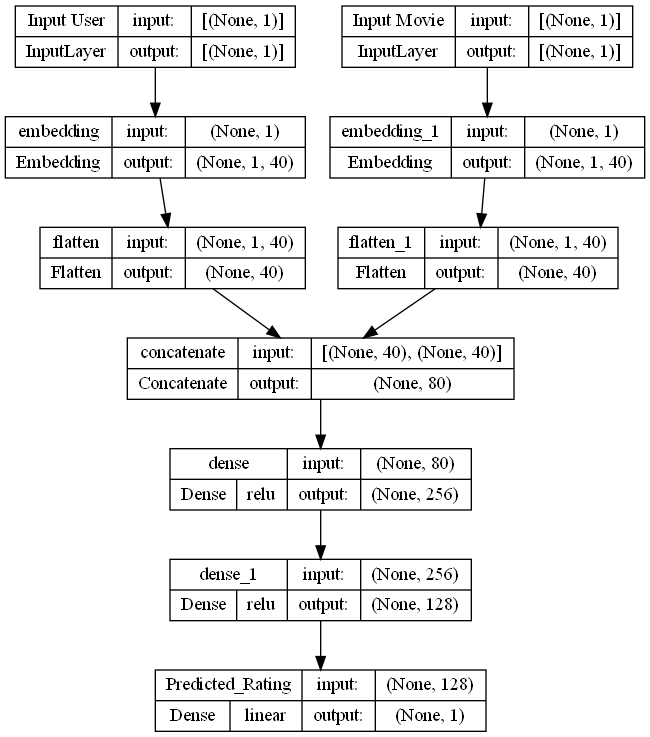

In [23]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [24]:
train_user = np.take(user_id, idx_train)
train_movie = np.take(movie_id, idx_train)
train_ratings = np.take(rating, idx_train)

test_user = np.take(user_id, idx_test)
test_movie = np.take(movie_id, idx_test)
test_ratings = np.take(rating, idx_test)

In [25]:
%%time

r = model.fit(x=[train_user, train_movie],
             y=train_ratings,
             epochs=15,
             batch_size=256,
             verbose='auto',
             validation_data=([test_user, test_movie], test_ratings))

print()

Epoch 1/15
334/334 [==============================] - 1s 2ms/step - loss: 1.2700 - val_loss: 1.0705
Epoch 2/15
334/334 [==============================] - 1s 2ms/step - loss: 1.0005 - val_loss: 0.9794
Epoch 3/15
334/334 [==============================] - 1s 2ms/step - loss: 0.9237 - val_loss: 0.9238
Epoch 4/15
334/334 [==============================] - 1s 2ms/step - loss: 0.8836 - val_loss: 0.8910
Epoch 5/15
334/334 [==============================] - 1s 2ms/step - loss: 0.8538 - val_loss: 0.8645
Epoch 6/15
334/334 [==============================] - 1s 2ms/step - loss: 0.8264 - val_loss: 0.8428
Epoch 7/15
334/334 [==============================] - 1s 2ms/step - loss: 0.8019 - val_loss: 0.8235
Epoch 8/15
334/334 [==============================] - 1s 2ms/step - loss: 0.7809 - val_loss: 0.8106
Epoch 9/15
334/334 [==============================] - 1s 2ms/step - loss: 0.7631 - val_loss: 0.8121
Epoch 10/15
334/334 [==============================] - 1s 2ms/step - loss: 0.7470 - val_loss: 0.7904

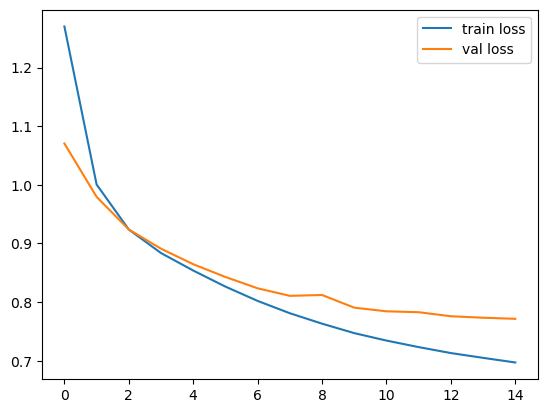

In [26]:
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

In [27]:
Predict_Rating

,userId,movieId,rating,cb_prediction
0,610,112818,3.0,3.269440
1,610,95377,4.0,4.160789
2,610,101525,4.0,4.046512
3,610,52950,3.0,3.141953
4,610,33679,3.0,3.571037
...,...,...,...,...
30,1,2387,5.0,4.550053
31,1,943,4.0,4.450228
32,1,3247,3.0,4.550053
33,1,1208,4.0,4.657230


In [28]:
mapping = new_data[['userId','new_userId','movieId','new_movieId']]

mapping

,userId,new_userId,movieId,new_movieId
14854,1,0,3033,2284
5909,1,0,1042,797
12959,1,0,2596,1956
12575,1,0,2542,1916
13354,1,0,2654,1993
...,...,...,...,...
100689,610,609,26498,5502
69727,610,609,60766,6786
53694,610,609,6373,4350
95104,610,609,111364,8408


In [29]:
# Mapping UserId dengan New_userId

userId_map = mapping[['userId','new_userId']]
movieId_map = mapping[['movieId','new_movieId']]

In [30]:
# Buat Dictionary untuk old id dengan new id

old_movieId = movieId_map['movieId'].astype(int).unique()
new_movieId = movieId_map['new_movieId'].unique()

In [31]:
c = {}
for i in range(len(old_movieId)):
    c[old_movieId[i]] = new_movieId[i]
    
c

{3033: 2284,
 1042: 797,
 2596: 1956,
 2542: 1916,
 2654: 1993,
 2450: 1841,
 231: 197,
 1793: 1325,
 316: 275,
 1136: 862,
 2947: 2216,
 2761: 2076,
 3703: 2761,
 2078: 1542,
 919: 701,
 3441: 2570,
 1206: 906,
 235: 201,
 923: 705,
 1927: 1406,
 608: 520,
 2571: 1938,
 3052: 2300,
 3448: 2576,
 2143: 1600,
 1617: 1217,
 3729: 2784,
 2640: 1985,
 2993: 2254,
 1024: 782,
 70: 62,
 2985: 2246,
 3439: 2568,
 3053: 2301,
 2291: 1703,
 3479: 2599,
 2366: 1767,
 1080: 819,
 1197: 898,
 2115: 1575,
 2502: 1882,
 2406: 1805,
 2858: 2144,
 2644: 1989,
 2048: 1516,
 954: 734,
 3386: 2523,
 2657: 1996,
 163: 136,
 3034: 2285,
 2616: 1970,
 1127: 855,
 1620: 1219,
 2648: 1990,
 1732: 1297,
 4006: 2987,
 2273: 1690,
 441: 384,
 423: 367,
 733: 592,
 3168: 2386,
 552: 484,
 157: 130,
 1500: 1145,
 296: 257,
 2116: 1576,
 2529: 1904,
 2353: 1754,
 2268: 1686,
 1210: 910,
 2617: 1971,
 333: 291,
 2161: 1616,
 367: 325,
 1348: 1035,
 1032: 789,
 480: 418,
 3440: 2569,
 356: 314,
 2395: 1795,
 3273: 24

In [32]:
def func(val):
    return c[val]

Predict_Rating['new_movieId'] = Predict_Rating['movieId'].apply(func)

In [33]:
Predict_Rating['new_userId'] = Predict_Rating['userId'] - 1

In [34]:
Predict_Rating['nn_prediction'] = model.predict([Predict_Rating['new_userId'], Predict_Rating['new_movieId']])

482/482 [==============================] - 0s 821us/step


In [35]:
# Hybrid Test

Predict_Rating['hybrid'] = Predict_Rating['cb_prediction'] * 0.1 + Predict_Rating['nn_prediction'] * 0.9

In [36]:
Predict_Rating

,userId,movieId,rating,cb_prediction,new_movieId,new_userId,nn_prediction,hybrid
0,610,112818,3.0,3.269440,8456,609,3.364139,3.354669
1,610,95377,4.0,4.160789,7901,609,3.610766,3.665768
2,610,101525,4.0,4.046512,8111,609,3.544960,3.595115
3,610,52950,3.0,3.141953,6461,609,3.560360,3.518519
4,610,33679,3.0,3.571037,5895,609,3.520683,3.525718
...,...,...,...,...,...,...,...,...
30,1,2387,5.0,4.550053,1787,0,4.455188,4.464675
31,1,943,4.0,4.450228,723,0,4.247894,4.268127
32,1,3247,3.0,4.550053,2432,0,3.977965,4.035174
33,1,1208,4.0,4.657230,908,0,5.133348,5.085736


In [37]:
total_predict = total_predict[total_predict['movieId'].isin(c.keys())]
total_predict['new_userId'] = total_predict['userId'] - 1

total_predict['new_movieId'] = total_predict['movieId'].apply(func)

In [38]:
total_predict = total_predict[['userId','movieId','new_userId','new_movieId','title','predict']]

total_predict

,userId,movieId,new_userId,new_movieId,title,predict
1,1,2,0,1,Jumanji (1995),4.315944
3,1,4,0,3,Waiting to Exhale (1995),4.380975
4,1,5,0,4,Father of the Bride Part II (1995),4.456268
6,1,7,0,6,Sabrina (1995),4.291423
7,1,8,0,7,Tom and Huck (1995),4.488280
...,...,...,...,...,...,...
9737,610,193581,609,9719,Black Butler: Book of the Atlantic (2017),3.744748
9738,610,193583,609,9720,No Game No Life: Zero (2017),3.886519
9739,610,193585,609,9721,Flint (2017),3.909374
9740,610,193587,609,9722,Bungo Stray Dogs: Dead Apple (2018),3.834365


In [39]:
total_predict['nn_predict'] = model.predict([total_predict['new_userId'], total_predict['new_movieId']])

182213/182213 [==============================] - 153s 842us/step


In [113]:
# Hybrid Unseen Movie

total_predict['hybrid'] = total_predict['predict'] * 0.2 + total_predict['nn_predict'] * 0.8

In [41]:
# Unseen Movie Predict

total_predict

,userId,movieId,new_userId,new_movieId,title,predict,nn_predict,hybrid
1,1,2,0,1,Jumanji (1995),4.315944,4.301964,4.303362
3,1,4,0,3,Waiting to Exhale (1995),4.380975,3.671928,3.742833
4,1,5,0,4,Father of the Bride Part II (1995),4.456268,3.862401,3.921788
6,1,7,0,6,Sabrina (1995),4.291423,3.926934,3.963383
7,1,8,0,7,Tom and Huck (1995),4.488280,4.069255,4.111157
...,...,...,...,...,...,...,...,...
9737,610,193581,609,9719,Black Butler: Book of the Atlantic (2017),3.744748,4.172005,4.129279
9738,610,193583,609,9720,No Game No Life: Zero (2017),3.886519,3.339877,3.394541
9739,610,193585,609,9721,Flint (2017),3.909374,3.681300,3.704107
9740,610,193587,609,9722,Bungo Stray Dogs: Dead Apple (2018),3.834365,3.437541,3.477223


## Metrics

In [42]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for index, row in predictions.iterrows(): 
        uid = row['userId']
        user_est_true[uid].append((row['prediction'], row['rating']))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [114]:
# Metrics Content Based

title = "Content Based"

df_test = Predict_Rating[['userId','movieId','rating','cb_prediction']]
df_test.columns = ['userId','movieId','rating','prediction']

precisions_, recalls_ = precision_recall_at_k(df_test, k=10, threshold=3.5)

avg_precision = sum(precisions_.values()) / len(precisions_)
avg_recall = sum(recalls_.values()) / len(recalls_)

rmse = mean_squared_error(df_test['rating'],df_test['prediction'], squared=False)

print(title)
print("===========================")
print("Average Precision @ 10 --->", avg_precision)
print("Average Recall    @ 10 --->", avg_recall)
print("RMSE                   --->", rmse)

Content Based
Average Precision @ 10 ---> 0.6913622170179553
Average Recall    @ 10 ---> 0.5174159151220605
RMSE                   ---> 0.9203236029413142


In [115]:
# Metrics Neural Network

title = "Neural Network CF"

df_test = Predict_Rating[['userId','movieId','rating','nn_prediction']]
df_test.columns = ['userId','movieId','rating','prediction']

precisions_, recalls_ = precision_recall_at_k(df_test, k=10, threshold=3.5)

avg_precision = sum(precisions_.values()) / len(precisions_)
avg_recall = sum(recalls_.values()) / len(recalls_)

rmse = mean_squared_error(df_test['rating'],df_test['prediction'], squared=False)

print(title)
print("===========================")
print("Average Precision @ 10 --->", avg_precision)
print("Average Recall    @ 10 --->", avg_recall)
print("RMSE                   --->", rmse)

Neural Network CF
Average Precision @ 10 ---> 0.7441276346604216
Average Recall    @ 10 ---> 0.5777552620825169
RMSE                   ---> 0.828657547541706


In [116]:
# Metrics Hybrid

title = "Hybrid"

df_test = Predict_Rating[['userId','movieId','rating','hybrid']]
df_test.columns = ['userId','movieId','rating','prediction']

precisions_, recalls_ = precision_recall_at_k(df_test, k=10, threshold=3.5)

avg_precision = sum(precisions_.values()) / len(precisions_)
avg_recall = sum(recalls_.values()) / len(recalls_)

rmse = mean_squared_error(df_test['rating'],df_test['prediction'], squared=False)

print(title)
print("===========================")
print("Average Precision @ 10 --->", avg_precision)
print("Average Recall    @ 10 --->", avg_recall)
print("RMSE                   --->", rmse)

Hybrid
Average Precision @ 10 ---> 0.7488836846213898
Average Recall    @ 10 ---> 0.5794627114752914
RMSE                   ---> 0.8233381408651496


In [46]:
# Make Top N Rekomendasi

# Top 10 Rekomendasi untuk setiap User

def Get_Recommendation(user, n, model="cb"):
    
    """
    Ambil Top N Rekomendasi dari User:
    
    
    
    >>> Output :
    
    6122                  Bandidas (2006)
    4513            Medallion, The (2003)
    325                  Mask, The (1994)
    7505        Warrior's Way, The (2010)
    1061                Young Guns (1988)
    3462          American Outlaws (2001)
    1523    Hot Lead and Cold Feet (1978)
    6774                   Hancock (2008)
    7503         Green Hornet, The (2011)
    5634                    Monday (2000)
    
    @Author : David Jose Giraldy
    ---------------------------------------------
    
    """
    if model == "cb":
        val = 'predict'
    
    elif model == "nn":
        val = 'nn_predict'
    
    elif model =="hb":
        val = 'hybrid'
    
    top_10 = total_predict[total_predict['userId'] == user].sort_values(by=val, ascending=False).head(n)
    top_10 = top_10[['userId','movieId','title',val]]

    return top_10

In [47]:
Get_Recommendation(1,10, "hb")

,userId,movieId,title,hybrid
277,1,318,"Shawshank Redemption, The (1994)",5.216057
906,1,1204,Lawrence of Arabia (1962),5.189532
937,1,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",5.175359
9618,1,177593,"Three Billboards Outside Ebbing, Missouri (2017)",5.153300
659,1,858,"Godfather, The (1972)",5.134974
841,1,1104,"Streetcar Named Desire, A (1951)",5.126026
686,1,904,Rear Window (1954),5.121480
602,1,750,Dr. Strangelove or: How I Learned to Stop Worr...,5.109549
3984,1,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,5.107402
596,1,741,Ghost in the Shell (Kôkaku kidôtai) (1995),5.104530


In [48]:
total_predict[total_predict['title'].str.contains("Kiki's Delivery")].sort_values(by='hybrid', ascending=False)

,userId,movieId,new_userId,new_movieId,title,predict,nn_predict,hybrid
5546,543,26662,542,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,6.316938,5.069527,5.194268
5546,43,26662,42,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,4.921909,5.216026,5.186615
5546,53,26662,52,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,5.000000,5.079464,5.071518
5546,452,26662,451,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,4.286395,5.101838,5.020294
5546,523,26662,522,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,4.466946,5.009402,4.955157
...,...,...,...,...,...,...,...,...
5546,567,26662,566,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,2.433952,2.807700,2.770325
5546,22,26662,21,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,2.127554,2.822273,2.752801
5546,139,26662,138,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,2.876303,2.697755,2.715610
5546,153,26662,152,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,2.457716,2.628966,2.611841


In [49]:
tp = total_predict.reset_index().drop("index", axis=1).copy()

In [50]:
tp

,userId,movieId,new_userId,new_movieId,title,predict,nn_predict,hybrid
0,1,2,0,1,Jumanji (1995),4.315944,4.301964,4.303362
1,1,4,0,3,Waiting to Exhale (1995),4.380975,3.671928,3.742833
2,1,5,0,4,Father of the Bride Part II (1995),4.456268,3.862401,3.921788
3,1,7,0,6,Sabrina (1995),4.291423,3.926934,3.963383
4,1,8,0,7,Tom and Huck (1995),4.488280,4.069255,4.111157
...,...,...,...,...,...,...,...,...
5830799,610,193581,609,9719,Black Butler: Book of the Atlantic (2017),3.744748,4.172005,4.129279
5830800,610,193583,609,9720,No Game No Life: Zero (2017),3.886519,3.339877,3.394541
5830801,610,193585,609,9721,Flint (2017),3.909374,3.681300,3.704107
5830802,610,193587,609,9722,Bungo Stray Dogs: Dead Apple (2018),3.834365,3.437541,3.477223


In [51]:
# test totoro similar

tu = tp[tp['title'] == "Kiki's Delivery Service (Majo no takkyûbin) (1989)"].sort_values(by='predict', ascending=False)
tu

,userId,movieId,new_userId,new_movieId,title,predict,nn_predict,hybrid
5191359,543,26662,542,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,6.316938,5.069527,5.194268
2582189,270,26662,269,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,5.855722,3.778026,3.985795
1076502,113,26662,112,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,5.601742,4.102622,4.252534
5152768,539,26662,538,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,5.500327,4.286930,4.408269
1825083,191,26662,190,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,5.462927,4.181255,4.309422
...,...,...,...,...,...,...,...,...
5392577,564,26662,563,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,1.123760,4.160543,3.856865
722489,76,26662,75,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,0.980380,3.376805,3.137163
2437703,255,26662,254,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,0.940313,3.078352,2.864548
1211111,127,26662,126,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,0.863219,3.847198,3.548800


In [52]:
judul = tu['title'].values[0]

In [53]:
tu = tu.reset_index().iloc[0]['userId']

tu

543

In [54]:
tu = tp[tp['userId'] == tu].sort_values(by='hybrid', ascending=False)

tu

,userId,movieId,new_userId,new_movieId,title,predict,nn_predict,hybrid
5190172,543,6350,542,4342,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,7.040473,5.246481,5.425881
5189811,543,5618,542,3979,Spirited Away (Sen to Chihiro no kamikakushi) ...,6.066667,5.307276,5.383215
5190837,543,7802,542,5011,"Warriors, The (1979)",6.096663,5.293757,5.374048
5186767,543,1199,542,900,Brazil (1985),5.637436,5.319154,5.350982
5191434,543,27156,542,5608,Neon Genesis Evangelion: The End of Evangelion...,6.039265,5.241734,5.321487
...,...,...,...,...,...,...,...,...
5186926,543,1381,542,1063,Grease 2 (1982),3.195830,3.324978,3.312063
5186205,543,374,542,332,Richie Rich (1994),3.878458,3.215624,3.281907
5188521,543,3593,542,2679,Battlefield Earth (2000),4.409519,3.129837,3.257805
5187169,543,1760,542,1311,Spice World (1997),3.701766,3.113164,3.172024


In [55]:
tu = tu.reset_index()

tu

,index,userId,movieId,new_userId,new_movieId,title,predict,nn_predict,hybrid
0,5190172,543,6350,542,4342,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,7.040473,5.246481,5.425881
1,5189811,543,5618,542,3979,Spirited Away (Sen to Chihiro no kamikakushi) ...,6.066667,5.307276,5.383215
2,5190837,543,7802,542,5011,"Warriors, The (1979)",6.096663,5.293757,5.374048
3,5186767,543,1199,542,900,Brazil (1985),5.637436,5.319154,5.350982
4,5191434,543,27156,542,5608,Neon Genesis Evangelion: The End of Evangelion...,6.039265,5.241734,5.321487
...,...,...,...,...,...,...,...,...,...
9643,5186926,543,1381,542,1063,Grease 2 (1982),3.195830,3.324978,3.312063
9644,5186205,543,374,542,332,Richie Rich (1994),3.878458,3.215624,3.281907
9645,5188521,543,3593,542,2679,Battlefield Earth (2000),4.409519,3.129837,3.257805
9646,5187169,543,1760,542,1311,Spice World (1997),3.701766,3.113164,3.172024


In [56]:
tu[tu['title'] == judul]

,index,userId,movieId,new_userId,new_movieId,title,predict,nn_predict,hybrid
42,5191359,543,26662,542,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,6.316938,5.069527,5.194268


In [57]:
idx = tu[tu['title'] == judul].index[0]

In [58]:
idx

42

In [59]:
tu.iloc[idx:idx+11]

,index,userId,movieId,new_userId,new_movieId,title,predict,nn_predict,hybrid
42,5191359,543,26662,542,5533,Kiki's Delivery Service (Majo no takkyûbin) (1...,6.316938,5.069527,5.194268
43,5186825,543,1261,542,959,Evil Dead II (Dead by Dawn) (1987),5.973926,5.107472,5.194118
44,5186380,543,593,542,510,"Silence of the Lambs, The (1991)",6.175035,5.081701,5.191035
45,5186694,543,1089,542,827,Reservoir Dogs (1992),5.064657,5.195030,5.181993
46,5186470,543,750,542,602,Dr. Strangelove or: How I Learned to Stop Worr...,3.521471,5.366015,5.181561
47,5193551,543,91355,542,7742,Asterix and the Vikings (Astérix et les Viking...,6.332720,5.049791,5.178084
48,5191508,543,27773,542,5682,Old Boy (2003),4.085376,5.297160,5.175982
49,5187766,543,2542,542,1916,"Lock, Stock & Two Smoking Barrels (1998)",5.265337,5.162973,5.173209
50,5186826,543,1262,542,960,"Great Escape, The (1963)",4.426376,5.252397,5.169795
51,5188102,543,3000,542,2258,Princess Mononoke (Mononoke-hime) (1997),6.162838,5.053227,5.164188


## Save Data

In [106]:
# Unseen Movies
joblib.dump(total_predict, "Unseen_Movies_Predicted_Rating_v2.joblib")

['Unseen_Movies_Predicted_Rating_v2.joblib']

In [107]:
# Seen Movies Test Predict For Metrics
joblib.dump(Predict_Rating, "Seen_Movies_Predicted_Rating_Metrics_v2.joblib")

['Seen_Movies_Predicted_Rating_Metrics_v2.joblib']

In [108]:
# Full Train Dataset
joblib.dump(full_Train, "Dataset_Train_v2.joblib")

['Dataset_Train_v2.joblib']

In [109]:
# Full Test Dataset
joblib.dump(full_Test, "Dataset_Test_v2.joblib")

['Dataset_Test_v2.joblib']

In [110]:
# Deep Learning Model
model.save("DNN_Model_v2.h5")

In [111]:
# Df Test
joblib.dump(Predict_Rating, "Test_Metrics_v2.joblib")

['Test_Metrics_v2.joblib']

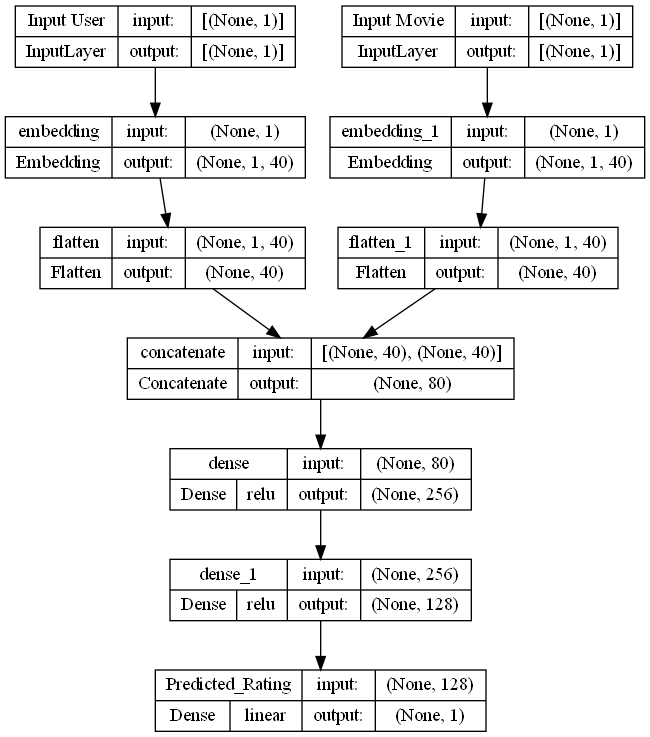

In [112]:
# Save Model Architecture
plot_model(model, 
           to_file='DNN_Model_Architecture_v2.png', 
           show_shapes=True, 
           show_layer_names=True, 
           show_layer_activations=True, 
           show_dtype=False)

In [101]:
Predict_Rating['0.9NN'] = 0.9 * Predict_Rating['nn_prediction'] + 0.1 * Predict_Rating['cb_prediction']
y_true = Predict_Rating['rating']
y_pred = Predict_Rating['0.9NN']
mean_squared_error(y_true, y_pred, squared=False)

0.8233381408651496

In [102]:
Predict_Rating['0.8NN'] = 0.8 * Predict_Rating['nn_prediction'] + 0.2 * Predict_Rating['cb_prediction']
y_true = Predict_Rating['rating']
y_pred = Predict_Rating['0.8NN']
mean_squared_error(y_true, y_pred, squared=False)

0.8213486412684681

In [103]:
Predict_Rating['0.7NN'] = 0.7 * Predict_Rating['nn_prediction'] + 0.3 * Predict_Rating['cb_prediction']
y_true = Predict_Rating['rating']
y_pred = Predict_Rating['0.7NN']
mean_squared_error(y_true, y_pred, squared=False)

0.8227131945557273

In [104]:
Predict_Rating['0.6NN'] = 0.6 * Predict_Rating['nn_prediction'] + 0.4 * Predict_Rating['cb_prediction']
y_true = Predict_Rating['rating']
y_pred = Predict_Rating['0.6NN']
mean_squared_error(y_true, y_pred, squared=False)

0.8274152164296155

In [105]:
Predict_Rating

,userId,movieId,rating,cb_prediction,new_movieId,new_userId,nn_prediction,hybrid,coba,0.9NN,0.8NN,0.7NN,0.6NN
0,610,112818,3.0,3.269440,8456,609,3.364139,3.354669,3.354669,3.354669,3.345199,3.335729,3.326260
1,610,95377,4.0,4.160789,7901,609,3.610766,3.665768,3.665768,3.665768,3.720770,3.775773,3.830775
2,610,101525,4.0,4.046512,8111,609,3.544960,3.595115,3.595115,3.595115,3.645271,3.695426,3.745581
3,610,52950,3.0,3.141953,6461,609,3.560360,3.518519,3.518519,3.518519,3.476678,3.434838,3.392997
4,610,33679,3.0,3.571037,5895,609,3.520683,3.525718,3.525718,3.525718,3.530754,3.535789,3.540825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,1,2387,5.0,4.550053,1787,0,4.455188,4.464675,4.464675,4.464675,4.474161,4.483648,4.493134
31,1,943,4.0,4.450228,723,0,4.247894,4.268127,4.268127,4.268127,4.288361,4.308594,4.328828
32,1,3247,3.0,4.550053,2432,0,3.977965,4.035174,4.035174,4.035174,4.092383,4.149591,4.206800
33,1,1208,4.0,4.657230,908,0,5.133348,5.085736,5.085736,5.085736,5.038124,4.990513,4.942901
